In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 464 kB/s 
     |████████████████████████████████| 5.8 MB 58.9 MB/s 
     |████████████████████████████████| 1.3 MB 58.3 MB/s 
     |████████████████████████████████| 182 kB 72.4 MB/s 
     |████████████████████████████████| 7.6 MB 25.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=75ba364ee24ff38d8d6e083ff4111b402d38d3eacc5410a911b14eb3943d1213
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
import os
import numpy as np
import gzip
import json
import pandas as pd
from scipy.cluster.vq import *

Load data from gzip json files

In [123]:
def load_data(file_name, head = 500000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [124]:
children = load_data(os.path.join("./", '/content/drive/MyDrive/Data/goodreads_books_children.json.gz'))
child_df=pd.DataFrame.from_records(children)

We have identified some common popular genres from popular_shelves column of bookd daatframe and stored it in child_genres list. We perform one hot encoding the match the genres which is present for every single book.

In [125]:
child_genres=["classic",'favorite','fiction','children','fantasy','young-adult','childhood','kids','adventure','animal','school','picture-books','library','other']
def apply_genre(r):
  encode=["0"]*len(child_genres)
  for val in r['popular_shelves']:

    for idx,g in enumerate(child_genres):
      if val['name'] in g:
        encode[idx]="1"
  return "".join(encode)

child_df["genre"]=child_df.apply(lambda row: apply_genre(row), axis=1)
child_df["genre"]=child_df["genre"].astype(str)
child_df["genre_len"]=child_df["genre"].apply(lambda x: len(x))
child_df.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,genre,genre_len
0,1599150603,7,[],US,,"[{'count': '56', 'name': 'to-read'}, {'count':...",,false,4.13,B00DU10PUG,...,2006,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,287141,46,278578,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls,10011000001000,14
1,1934876569,6,[151854],US,,"[{'count': '515', 'name': 'to-read'}, {'count'...",,false,4.22,,...,2009,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,6066812,98,701117,All's Fairy in Love and War (Avalon: Web of Ma...,All's Fairy in Love and War (Avalon: Web of Ma...,11111111110111,14
2,0590417010,193,[],US,eng,"[{'count': '450', 'name': 'to-read'}, {'count'...",,false,4.43,B017RORXNI,...,1995,https://www.goodreads.com/book/show/89378.Dog_...,https://images.gr-assets.com/books/1360057676m...,89378,1331,86259,Dog Heaven,Dog Heaven,11111111111110,14


Accessing preprocessed data

In [126]:
import pandas as pd 
final_df=pd.read_csv("/content/drive/MyDrive/Data/final_data.csv")
child_books=child_df

In [127]:
child_books["genre"]=child_books["genre"].astype(str)
books_genre=child_books.set_index('book_id').to_dict()['genre']


Every book will have multiple user rating and multiple reviews from different users. So we aggregate those reviews and join them togehter and we take a mean of the user ratings.

In [128]:
final_df["book_genre"]=final_df["book_id"].apply(lambda x:books_genre.get(str(x), "00000000000000"),0)
final_df.dropna(inplace=True)
grouped_df = final_df.groupby(['language_code', 'is_ebook','average_rating','similar_books','description'
,'publisher','title','book_id','book_genre','author_ids','n_votes'
]).agg({'rating': 'mean','review_text':' '.join}).reset_index()


In [129]:
grouped_df["review_length"]=grouped_df["review_text"].apply(lambda x: len(x))
grouped_df["description_len"]=grouped_df["description"].apply(lambda x: len(x))
grouped_df=grouped_df[grouped_df["language_code"].isin(["eng","en-US","en-GB"])]
grouped_df.head(2)

,language_code,is_ebook,average_rating,similar_books,description,publisher,title,book_id,book_genre,author_ids,n_votes,rating,review_text,review_length,description_len
2068,en-GB,False,2.60,[],Big Pig's Sister and her friend have been to t...,Hodder Children's Books,Wibbly Pig and the Tooky,18586838,00010001000000,['77009'],0.0,3.0,"Cute, especially the pictures. Would have like...",290,113
2069,en-GB,False,2.67,[],"Imagine Tirion's feelings: ten years old, and ...",Pont,Tirion's Secret Journal,11136325,00000000000000,['42859'],0.0,3.0,"Very cute, and nicely informative too - loads ...",605,452


In [130]:
final_df["book_genre"].value_counts()

11111111101110    18020
00111111100110    11916
00110001000110     9987
10111111101110     7794
00111100101101     7230
                  ...  
10111110001110        1
01101100001000        1
01010000101100        1
00111001110001        1
10011101000110        1
Name: book_genre, Length: 2520, dtype: int64

The following plot shows that the length of most of book descriptions are lying mostly around 1000 characters, while few of them being as high as 16000 characters

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


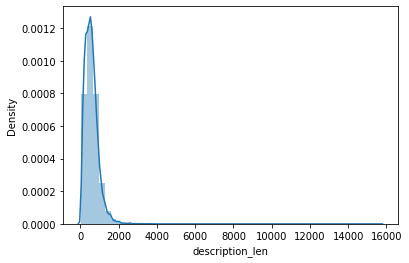

In [131]:

grouped_df["description_len"].max()
import seaborn as sns
sns.distplot(grouped_df['description_len'])

In [132]:
grouped_df["review_text"] = grouped_df["review_text"].fillna('')
grouped_df["description"] = grouped_df["description"].fillna('')
grouped_df["publisher"] = grouped_df["publisher"].fillna('')
grouped_df["title"] = grouped_df["title"].fillna('')

We combine these rows together to "combined" column and this column is going to have all the aggregated data of every single book. So each entry of this column acts like a single document containing all the information of a book.

In [133]:
def combine(r):
  return r['publisher']+' '+r['title']+' '+r['author_ids']+' '+str(r['average_rating'])+' '+r['book_genre']+' '+r['description']+' '+r['review_text']

In [134]:
grouped_df["combined"] =grouped_df.apply(combine, axis = 1)

In [16]:
from sentence_transformers import SentenceTransformer
grouped_df=grouped_df[:25000]
sbert = SentenceTransformer('all-mpnet-base-v2') #roberta model


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

We form sentence embedding of every document and save those embeddings 

In [19]:
# sentence_embeddings = sbert.encode(grouped_df['combined'].tolist())
sentence_embeddings=np.load("/content/drive/MyDrive/Data/sentence_embeddings_25000.npy")

In [ ]:

np.save("/content/drive/MyDrive/Data/sentence_embeddings_25000.npy",sentence_embeddings)


Apply Kmeans to these embeddings and obtain 100 clusters 

In [20]:
cluster_size = 100
cluster_centres,_ = kmeans(np.vstack(sentence_embeddings), cluster_size, 20)

In [21]:
vocabs = {' ': 0, '</s>': 1,'<s>': 2, '<bos>': 3}
for i in range(cluster_centres.shape[0]):
  w = str(i)
  vocabs[w] = i + 5
len(vocabs)

104

Save cluster centers and vocabulary files

In [22]:
np.save('/content/drive/MyDrive/Data/codebook_25000.npy', cluster_centres)
with open('/content/drive/MyDrive/Data/vocabs_25000.json', 'w') as outfile:
    json.dump(vocabs, outfile)

In [23]:
def title(index):
    return grouped_df[grouped_df.S_no == index]["title"].values[0]

Assign every embedding to its closest cluster

In [24]:
cluster, _ = vq(sentence_embeddings,cluster_centres)
grouped_df['cluster'] = cluster

In [25]:
description="""A picture book retelling of a traditional European tale with the events and meaning of the first Easter at its heartBoth thought-provoking 
and engaging, this is the story of Simon of Cyrene --"a man coming in from the country," as the Gospels refer to him--who was ordered to carry Jesus' 
cross. Over the centuries, his story has been woven into Polish folklore; when Simon the farmer brings his wares to market, little does he expect how he 
will be involved in the events of that very special day, nor how his produce--of bread, eggs, and wine--will become important symbols of Jesus' passion 
and resurrection, remembered throughout the ages.	"""
name="Simon and the Easter Miracle"


In [26]:
query_vector=sbert.encode(name+description)
queryCluster, _ = vq([query_vector],cluster_centres)

In [27]:
print("Cluster id of query book:",queryCluster[0])

Cluster id of query book: 85


In [28]:
def getElementsInTheSameCluster(centroid):
    cluster =grouped_df
    book_embeddings = sentence_embeddings
    cluster['embeddings_id'] = [i for i in range(0,book_embeddings.shape[0])]
    multiIndex_cluster = cluster.sort_values(by=['cluster'])
    multiIndex_cluster = multiIndex_cluster.set_index(['cluster'])
    books = multiIndex_cluster.loc[centroid]

    ids = np.asarray(books.index)
    titles = [t for t in books['title']]
    genre=[t for t in books['book_genre']]
    description = [d for d in books['description']]
    embeddings = [book_embeddings[id] for id in books['embeddings_id']]
    similar_books = {'id':ids, 'title':titles, 'description':description,'genre':genre}
    return similar_books, embeddings
similar_books, cluster_book_embeddings = getElementsInTheSameCluster(queryCluster[0])

In [29]:
for i in range(len(similar_books)):
    print("****************************************************************************")
    print("BookName         :",similar_books['title'][i])
    print("Book Description :",similar_books['description'][i])

****************************************************************************
BookName         : Claymore and Kilt: Tales of Scottish Kings and Castles
Book Description : Sorche Nic Leodhas, distinguished author of such favorites as 1966 Caldecott Medal Winner, Always Room For One More, illustrated by Nonny Hogrogrian, and Newbery Runner-up, Thistle and Thyme, follows these great successes with a delightful collection of stirring historial tales about Scottish kings, lairds, and chieftains from the time of King Fingal in 211 A.D. to King James VI in 1611 A.D.
Among the vivid characters peopling the tales are Kinmont Wullie, a rogue about whom it was said, "the Highlands never, before or after, bred a man so wild"; King James V, who often put on a beggar's coat and went through the realm to check the welfare of his subjects; Thalmar, the courageous daughter of the evil chieftain Dunthelm, who put on the armor of a knight to aid men wronged by her father; and the ruthless Lachlan MacLean 

In [30]:
#Calculate relevance of document based on matching number of book genres
def relevance(predicted,expected,total):
  child_genres=["classic",'favorite','fiction','children','fantasy','young-adult','childhood','kids','adventure','animal','school','picture-books','library','other']
  baseline=sum([1 for i in expected if i=="1"])
  rel_score=[]
  for p in predicted[:total]:
    score=0
    for idx,p in enumerate(p):
      if expected[idx]==p and p=="1":score+=1
    rel_score.append(score/(baseline+0.01)*1)
  return rel_score

#calculate precision with a threshold of 0.4
def precision(relevance_score):
  return sum([1 for i in relevance_score if i>0.4])/len(relevance_score)


In [31]:
def calculate_score(total=10):
  score=[]
  for row,d in grouped_df.iterrows():
    name=d["title"]
    desc=d["description"]
    #concatenate book name and description and get document embedding for the same
    query_vector=model.getEmbeddings(name+desc)
    #check qhich cluster it belongs to
    queryCluster, _ = vq(query_vector,bookCodebook)
    #Fetch books in the same cluster
    similar_books, cluster_book_embeddings = getElementsInTheSameCluster(queryCluster[0])
    book_g=d["book_genre"]
    similar_books=list(set(similar_books['genre']))
    #calculate precision@total
    relevance_score=relevance(similar_books,book_g,total)
    prec=precision(relevance_score)
    score.append(prec)
  return sum(score)/len(score)
  

In [32]:
result=calculate_score(5)
print("Precision @5: ",result)

Precision @5:  0.7563999999998663


In [33]:
result=calculate_score(10)
print("Precision @10: ",result)

Precision @10:  0.7764759999999761


In [35]:
result=calculate_score(25)
print("Precision @20: ",result)

Precision @20:  0.7294424276128904
